In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read

In [2]:
def comparator(input_data):
    output_data = np.zeros(len(input_data))

    rising = True
    previous_x = 0
    for n, x in enumerate(input_data):
        if rising == True and x < previous_x:
            rising = False
        elif rising == False and x > previous_x:
            rising = True

        output_data[n] = 1 if rising else -1
        previous_x = x
    return output_data

def clock_divider(input_data):
    output_data = np.zeros(len(input_data))

    rising = True
    previous_x = 0
    output = 1
    switch_count = 0
    for n, x in enumerate(input_data):
        output_data[n] = output

        if rising == True and x < previous_x:
            switch_count += 1
            rising = False
        elif rising == False and x > previous_x:
            switch_count += 1
            rising = True
        
        if switch_count == 2:
            output = 1 if output == -1 else -1
            switch_count = 0

        previous_x = x
    return output_data

In [3]:
N = 256
fs = 48000
freq = 2000

x = np.sin(2 * np.pi * freq / fs * np.arange(N)) * 0.5
y1 = comparator(x)
y2 = clock_divider(y1)

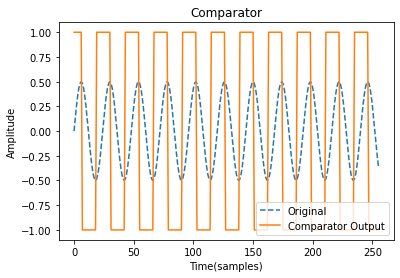

In [4]:
plt.plot(x, '--', label='Original')
plt.plot(y1, label='Comparator Output')
plt.title('Comparator')
plt.xlabel('Time(samples)')
plt.ylabel('Amplitude')
plt.legend(loc='lower right')
plt.show()

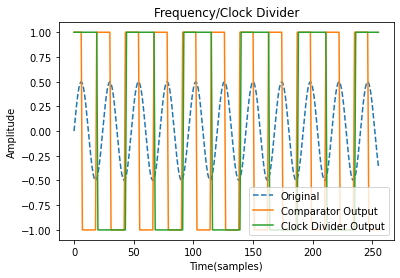

In [5]:
plt.plot(x, '--', label='Original')
plt.plot(y1, label='Comparator Output')
plt.plot(y2, label='Clock Divider Output')
plt.title('Frequency/Clock Divider')
plt.xlabel('Time(samples)')
plt.ylabel('Amplitude')
plt.legend(loc='lower right')
plt.show()

In [6]:
def PreProcessData(xn, frameSize, stepSize):
    xn = np.append(np.zeros(128), xn)
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

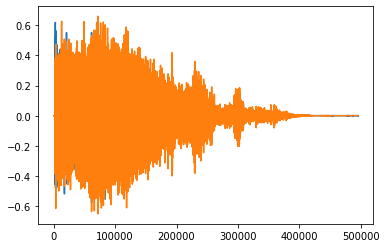

In [7]:
rate, file = read("explosion.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]

data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

numerator = [0.9636527639641732, -1.9273055279283464, 0.9636527639641732]
denominator = [1.0, -1.9259839697318857, 0.9286270861248074]

data0 = signal.lfilter(numerator, denominator, data0)
data1 = signal.lfilter(numerator, denominator, data1)

plt.plot(data0)
plt.plot(data1)
plt.show()

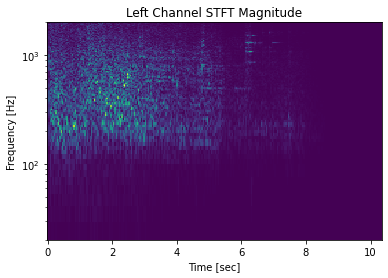

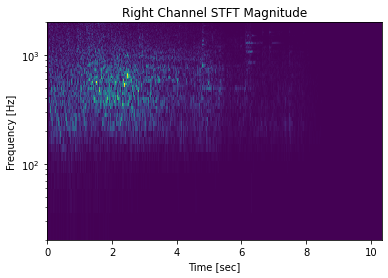

In [8]:
f0, t0, Zxx0 = signal.stft(data0, rate, nperseg=4096)
amplitude0 = 20 * np.log10(np.abs(Zxx0))
plt.pcolormesh(t0, f0, np.abs(Zxx0))
plt.title('Left Channel STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(20, 2000)
plt.show()

f1, t1, Zxx1 = signal.stft(data1, rate, nperseg=2048)
amplitude1 = 20 * np.log10(np.abs(Zxx1))
plt.pcolormesh(t1, f1, np.abs(Zxx1))
plt.title('Right Channel STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(20, 2000)
plt.show()

In [9]:
M = 2048
H = 128
W = signal.get_window("hann", M)

dataSet0, data0, length, iteration = PreProcessData(data0, M, H)
dataSet1, data1, length, iteration = PreProcessData(data1, M, H)

In [10]:
numerator = [0.0006607790982303967, 0.0013215581964607934, 0.0006607790982303967]
denominator = [1.0, -1.9259839697318857, 0.9286270861248074]

# clock divider
clock0 = clock_divider(comparator(data0))
clock1 = clock_divider(comparator(data1))

# envlope shaper(RMS or Pk2Pk)
env0 = clock0 * np.abs(data0)
env1 = clock1 * np.abs(data1)

# filter
output0 = signal.lfilter(numerator, denominator, env0)
output1 = signal.lfilter(numerator, denominator, env1)

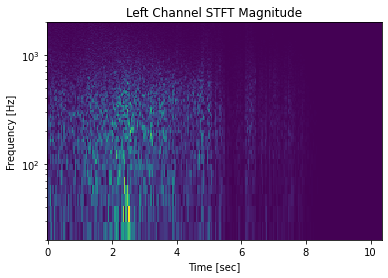

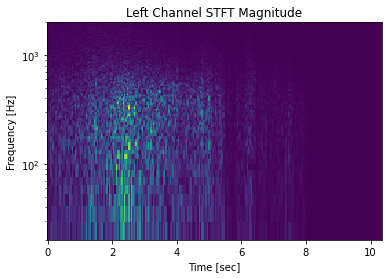

In [11]:
f0, t0, Zxx0 = signal.stft(output0, rate, nperseg=4096)
amplitude0 = 20 * np.log10(np.abs(Zxx0))
plt.pcolormesh(t0, f0, np.abs(Zxx0))
plt.title('Left Channel STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(20, 2000)
plt.show()

f0, t0, Zxx1 = signal.stft(output1, rate, nperseg=4096)
amplitude0 = 20 * np.log10(np.abs(Zxx1))
plt.pcolormesh(t0, f0, np.abs(Zxx1))
plt.title('Left Channel STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(20, 2000)
plt.show()

In [12]:
raw = np.array([data0 * 32767.0, data1 * 32767.0]).astype(np.int16).T
write("raw.wav", rate, raw)
IPython.display.display(IPython.display.Audio("raw.wav", rate=rate))

temp = np.array([output0 * 32767.0, output1 * 32767.0]).astype(np.int16).T
write("output.wav", rate, temp)
IPython.display.display(IPython.display.Audio("output.wav", rate=rate))

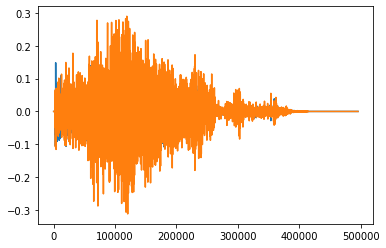

In [13]:
plt.plot(output0)
plt.plot(output1)
plt.show()